<a href="https://colab.research.google.com/github/sarangbishal/Ballot-Paper-Counting-System/blob/master/Balloot_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import all required libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import imutils
import cv2

from collections import Counter
from imutils.perspective import four_point_transform
from imutils import contours

### Read Image and detect edges using cv2 Canny algorithm

In [0]:
FILE_PATH = "sample__29.jpg"

In [0]:
# Read Image
image = cv2.imread(FILE_PATH)

# Since matplotlib uses different color space
# Convert to matplotlib space for debugging purpose in notebook
image_matplotlib_compat = imutils.opencv2matplotlib(image)

# Preprocess the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# edged = cv2.Canny(blurred, 75, 200)
# auto_edged = imutils.auto_canny(gray)

# plt.imsave("image_1.jpg", edged)
# plt.imshow(auto_edged)

### Add contour detection and isolate candidate boxes

In [0]:
thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# plt.imshow(thresh)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# List to grab each boxes contours
rows = []

# Find Most common contour area
most_common_area = Counter([cv2.contourArea(c) for c in cnts if len(cv2.approxPolyDP(c, 0.02 * cv2.arcLength(c, True), True)) == 4]).most_common(1)[0][0]
# Consider contour area upto this threshold
area_delta  = 999

# Read original image which is later modified 
# by filling each boxes with black color so as
# to detect red color only outside the boxes for invalid
image_modified = cv2.imread(FILE_PATH)
i = 0
# print(most_common_area)
for c in cnts:
    
    # Calculate Perimeter of Contour
    peri = cv2.arcLength(c, True)
    # Approximate a closed polygon with minimum number of points
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # Calculate area of current contour
    current_contour_area = cv2.contourArea(c)
    # print(current_contour_area)
    
    # If 4 corners are found and contour area satisfy minimum threshold
    if len(approx) == 4  and abs(current_contour_area - most_common_area) <= area_delta:
        
        # Fill each boxes with black color inorder to detect red color only outside the boxes
        cv2.fillPoly(image_modified, pts =[approx], color=(0,0,0))
        rows.append(c)

if len(rows) != 39:
    print("Invalid Ballot Paper")
    print(len(rows))
#plt.imsave("testp.jpg",imutils.opencv2matplotlib(image_modified))

### Arrange each boxes in the order as they appear on paper

In [29]:
# First sort contours in top to bottom manner
rows = contours.sort_contours(rows, method="top-to-bottom")[0]

k = 0

# List to store sorted boxes as they appear on paper
sorted_boxes = []

# For every 3 columns sort them according to left to right
# and add to sorted boxes
for (q, i) in enumerate(np.arange(0, len(rows), 3)):
    cnts = contours.sort_contours(rows[i:i + 3], method = "left-to-right")[0]
    sorted_boxes.extend(cnts)

print(len(sorted_boxes))

# List to store isolated box image converted to HSV color space
# for color detection and masking
isolated_box_img = list()

#
for c in sorted_boxes:
    k += 1
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    isolated_box_matplotlib_compat = four_point_transform(image_matplotlib_compat, approx.reshape(4, 2))
    isolated_box_org = four_point_transform(image, approx.reshape(4, 2))
    
    isolated_box_hsv = cv2.cvtColor(isolated_box_org, cv2.COLOR_BGR2HSV)
    
    isolated_box_img.append(isolated_box_hsv)
    # plt.imsave("naya/test_" + str(k) + ".jpg", isolated_box)

    
# plt.imsave("ou.jpg", image_matplotlib_compat)

39



## Verify if the paper is invalid or assign vote to particuular party if valid
*   If number of boxes != 39, it is either the box is not detected properly or marker sign crosses the boundary
*   If number of boxes == 39: then boxes are read properly
* Find red pixels inside each boxes
* If two or more than two boxes has marker, it is invalid
* If red color is detected outside the 39 boxes, then it is invalid




### Detect red colors inside any of the boxes
![Outside](https://github.com/sarangbishal/Ballot-Paper-Counting-System/blob/master/tests/Kathmanduoutside.jpg)


In [30]:
lower_red = np.array([0,120,70])
upper_red = np.array([10,255,255])
parties = [0] * 39
for i, hsv in enumerate(isolated_box_img):
    mask = cv2.inRange(hsv, lower_red, upper_red)
    
    # print(cv2.countNonZero(mask))
    
    if(np.any(mask != 0)):
        # Mark the position where color is found
        parties[i] = 1
        print("color found at index", i)
       
    # bgless = cv2.bitwise_and(image_matplotlib_compat,image_matplotlib_compat, mask= mask)
    # plt.imshow(bgless)   
    
    

color found at index 27


#### Color is found outside the box

In [0]:
def no_color_outside():
    # Convert full page image to hsv
    full_page_hsv = cv2.cvtColor(image_modified, cv2.COLOR_BGR2HSV)
    # Create a mask for red color
    mask =  cv2.inRange(full_page_hsv, lower_red, upper_red)
    
    # IF all pixels are black i.e no red detected
    return np.all(mask == 0)
    


The party at index 27 has got the vote


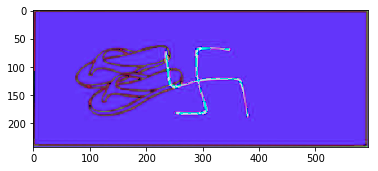

In [41]:
def isValid():
    # Returns True if all the boxes are detected, no color outside any of the boxes and color is found at only one index
    return len(sorted_boxes) == 39 and no_color_outside() and parties.count(1) == 1

if(isValid()):
    index = parties.index(1)
    print("The party at index {} has got the vote".format(index))
    plt.imshow(isolated_box_img[index])
else:
    print("Invalid")